# Spatiotemporal Travel Demand Analysis with NYC Taxi Trip Data Using Spatial Statistics - Spatial Statistics and Visualization

In [1]:
import esda
import libpysal
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
# warnings.filterwarnings('ignore')

In [2]:
grid_trip = gpd.read_file('/Users/jiyeonhwang/Downloads/python/공분 프로젝트/공분플젝 재분석 파일모음/grid_with_trips.shp')
grid_trip.head()

grid_id     dof_1     dof_2     dof_3     dof_4      pu_1      pu_2  \
0        0  7.120955  5.380277  5.380277  3.481356  8.703390  6.013251   
1        1  4.382237  3.311024  3.311024  2.142427  5.356068  3.700556   
2        2  2.866051  2.165460  2.165460  1.401180  3.502951  2.420221   
3        3  2.478995  1.873018  1.873018  1.211953  3.029883  2.093373   
4        4  6.373900  4.356580  4.212863  2.741188  6.522420  4.588449   

       pu_3      pu_4                                           geometry  
0  6.171495  5.063790  POLYGON ((918455.109 125401.881, 918455.109 12...  
1  3.797939  3.116258  POLYGON ((918455.109 130681.881, 918455.109 12...  
2  2.483911  2.038080  POLYGON ((918455.109 135961.881, 918455.109 13...  
3  2.148462  1.762841  POLYGON ((918455.109 135961.881, 916042.938 13...  
4  4.617672  3.435832  POLYGON ((923735.109 125401.881, 923735.109 12...

In [3]:
grid_trip.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US survey foot)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [4]:
# Calculate the bounding box (xmin, ymin, xmax, ymax) of the grid layer
xmin, ymin, xmax, ymax = grid_trip.total_bounds
width = xmax - xmin
height = ymax - ymin
print(width)
print(height)

154207.39939635992
152722.4127511233


Units are in feet. <br>
154,207.4 ft ≈ 47,002.4 m (≈ 47 km) <br>
Therefore, the search radius is set to 50 km (≈ 164,042 ft)

## Moran'I Queen

/opt/miniconda3/envs/open3d_env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There is 1 island with id: 393.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 393, ' is an island (no neighbors)')


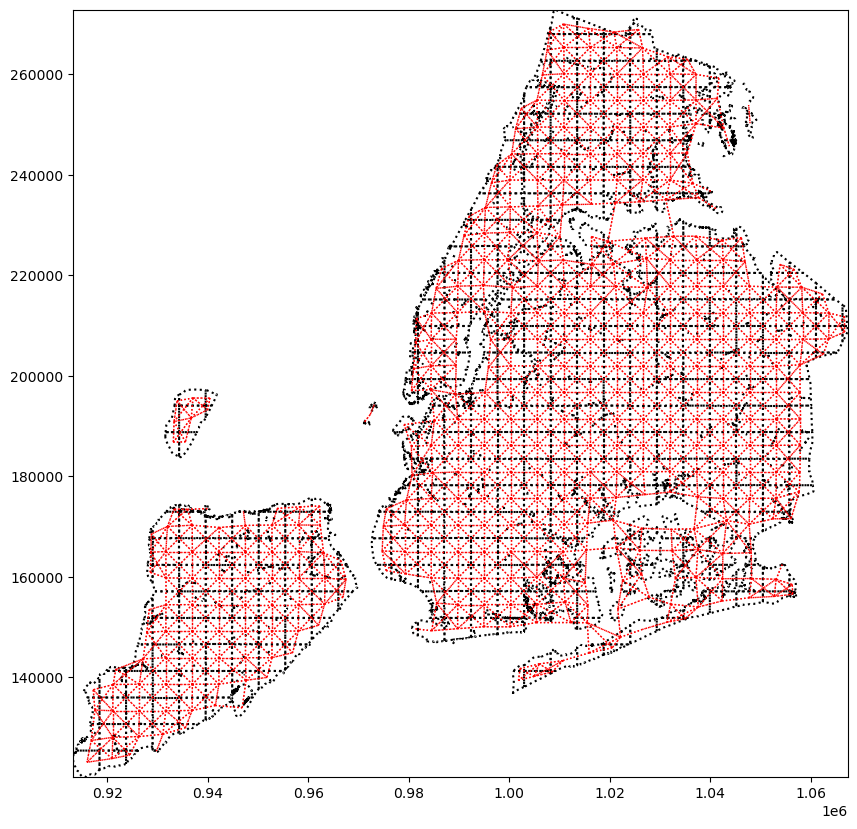

In [5]:
# Create a Queen contiguity-based spatial weights matrix
w_queen = libpysal.weights.Queen.from_dataframe(grid_trip, use_index=True)
y = grid_trip['pu_1']
mi_queen = esda.moran.Moran(y, w_queen) # Compute Moran's I using Queen contiguity weights

fig, ax = plt.subplots(1, 1, figsize=(10,10))
# Contiguity: Queen's case
grid_trip.boundary.plot(ax=ax, ls=':', color='black')
w_queen.plot(grid_trip, ax=ax, 
             edge_kws=dict(color='r', linestyle=':', linewidth=1),
             node_kws=dict(marker=''))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.show() # Display the plot to inspect how each grid cell is connected to its neighbors

In [17]:
list(w_queen.weights.items())[:5] # Spatial weights are row-standardized so that each neighboring cell receives an equal weight summing to 1 for each observation

[(0, [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]),
 (1, [0.2, 0.2, 0.2, 0.2, 0.2]),
 (2, [0.2, 0.2, 0.2, 0.2, 0.2]),
 (3, [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]),
 (4, [0.2, 0.2, 0.2, 0.2, 0.2])]

In [18]:
list(w_queen.neighbors.items())[:5] # contiguity matrix

[(0, [1, 4, 5]),
 (1, [0, 2, 4, 5, 6]),
 (2, [1, 3, 5, 6, 7]),
 (3, [2, 6, 7]),
 (4, [0, 1, 5, 9, 10])]

In [8]:
# Compute Global Moran's I using a Queen contiguity weights matrix
y = grid_trip['dof_4']

mi_queen = esda.moran.Moran(y, w_queen) 
print(f"Moran's I with Queen's case contiguity: {round(mi_queen.I, 3)}, p-value: {mi_queen.p_norm}, z-score: {round(mi_queen.z_norm, 5)}")

Moran's I with Queen's case contiguity: 0.734, p-value: 6.669405411262566e-140, z-score: 25.17979


# LISA

In [9]:
grid_trip.columns

Index(['grid_id', 'dof_1', 'dof_2', 'dof_3', 'dof_4', 'pu_1', 'pu_2', 'pu_3',
       'pu_4', 'geometry'],
      dtype='object')

In [10]:
col_list = ['dof_1', 'dof_2', 'dof_3', 'dof_4', 'pu_1', 'pu_2', 'pu_3', 'pu_4']

In [19]:

w_queen = libpysal.weights.Queen.from_dataframe(grid_trip, use_index=True)

# Mapping of Local Moran's I cluster types
lm_dict = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}

# Compute Local Moran's I (LISA) for each variable
for i in col_list:
    y = grid_trip[f'{i}']
    lm_queen = esda.moran.Moran_Local(y, w_queen, seed=17)
    lisa_queen = []
    # Assign LISA cluster labels based on significance and quadrant
    for idx in range(len(lm_queen.q)):
        if lm_queen.p_sim[idx] < 0.05:
            lisa_queen.append(lm_dict[lm_queen.q[idx]])
        else:
            lisa_queen.append('Not_Sig')

    # Store LISA cluster labels in the GeoDataFrame
    grid_trip[f'lisa_{i}'] = lisa_queen


grid_trip.head()


('WARNING: ', 393, ' is an island (no neighbors)')


/opt/miniconda3/envs/open3d_env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There is 1 island with id: 393.
  W.__init__(self, neighbors, ids=ids, **kw)
/opt/miniconda3/envs/open3d_env/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/opt/miniconda3/envs/open3d_env/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/opt/miniconda3/envs/open3d_env/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/opt/miniconda3/envs/open3d_env/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_si

grid_id     dof_1     dof_2     dof_3     dof_4      pu_1      pu_2  \
0        0  7.120955  5.380277  5.380277  3.481356  8.703390  6.013251   
1        1  4.382237  3.311024  3.311024  2.142427  5.356068  3.700556   
2        2  2.866051  2.165460  2.165460  1.401180  3.502951  2.420221   
3        3  2.478995  1.873018  1.873018  1.211953  3.029883  2.093373   
4        4  6.373900  4.356580  4.212863  2.741188  6.522420  4.588449   

       pu_3      pu_4                                           geometry  \
0  6.171495  5.063790  POLYGON ((918455.109 125401.881, 918455.109 12...   
1  3.797939  3.116258  POLYGON ((918455.109 130681.881, 918455.109 12...   
2  2.483911  2.038080  POLYGON ((918455.109 135961.881, 918455.109 13...   
3  2.148462  1.762841  POLYGON ((918455.109 135961.881, 916042.938 13...   
4  4.617672  3.435832  POLYGON ((923735.109 125401.881, 923735.109 12...   

  lisa_dof_1 lisa_dof_2 lisa_dof_3 lisa_dof_4 lisa_pu_1 lisa_pu_2 lisa_pu_3  \
0         LL         LL         LL         LL        LL        LL        LL   
1         LL         LL         LL         LL        LL        LL        LL   
2         LL         LL         LL         LL        LL        LL        LL   
3         LL         LL         LL         LL        LL        LL        LL   
4         LL         LL         LL         LL        LL        LL        LL   

  lisa_pu_4  
0        LL  
1        LL  
2        LL  
3        LL  
4        LL

In [20]:
grid_trip['dof_4'].sort_values(ascending=False).head()

120    5836.235648
119    5492.938406
136    5331.237263
135    4424.173386
121    3758.921592
Name: dof_4, dtype: float64

In [13]:
# Generate and save interactive LISA cluster maps for each variable
for i in col_list:
    m = grid_trip.explore(
        column=f"lisa_{i}",     
        cmap=['red', 'skyblue', 'blue', 'orange', 'lightgrey'],  
        categories=["HH", "LH", "LL", "HL", "Not_Sig"],           
        legend=True,                    
        tiles="CartoDB positron",      
        tooltip=f"{i}",     
        style_kwds={'fillOpacity': 0.6, 'weight': 0.5, 'color': 'black'}  
        )
    
    # m.save(f'/Users/jiyeonhwang/Downloads/python/공분 프로젝트/공분플젝 재분석 파일모음/lisa_map_{i}_value.html')


In [14]:


grid_trip.explore(
    column="lisa_pu_1",      # 색상을 지정할 컬럼
    cmap=['red', 'skyblue', 'blue', 'orange', 'lightgrey'],  # 색상 리스트 (HH, LH, LL, HL, Not_Sig 순)
    categories=["HH", "LH", "LL", "HL", "Not_Sig"],           # 범주 순서 명시
    legend=True,                     # 범례 표시
    tiles="CartoDB positron",       # 배경지도 스타일
    tooltip="lisa_pu_1",     # 마우스오버시 보여줄 정보
    style_kwds={'fillOpacity': 0.6, 'weight': 0.5, 'color': 'black'}  # 경계선 스타일
)

#### Red (HH) and blue (LL) indicate statistically significant hot spots and cold spots, respectively, while LH and HL represent spatial outliers. Areas with no significant spatial autocorrelation are shown in light grey.

In [22]:
y = grid_trip['dof_1']  # Focused Variable
w_queen = libpysal.weights.Queen.from_dataframe(grid_trip, use_index=True) # Contiguity weight # queen's 인접성 행렬 계산
 
lm_queen = esda.moran.Moran_Local(y, w_queen, seed=17) # seed 파라미터 = 리사는 확률이기 때문에 돌릴때마다 값이 달라짐. 따라서 랜덤한걸 고정시키는 역할.
print(lm_queen.q[:30]) # Classification of LISA # q = qunatile
print(lm_queen.p_sim[:30]) # Significance of each classification # p-value 계산

('WARNING: ', 393, ' is an island (no neighbors)')
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[0.02  0.002 0.002 0.017 0.002 0.001 0.001 0.001 0.022 0.026 0.001 0.001
 0.001 0.001 0.004 0.022 0.065 0.012 0.059 0.237 0.001 0.002 0.002 0.001
 0.001 0.002 0.005 0.003 0.003 0.06 ]


/opt/miniconda3/envs/open3d_env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There is 1 island with id: 393.
  W.__init__(self, neighbors, ids=ids, **kw)
/opt/miniconda3/envs/open3d_env/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


In [23]:
lm_dict = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}

lisa_queen = []
for idx in range(len(lm_queen.q)):
    if lm_queen.p_sim[idx] < 0.05:
        lisa_queen.append(lm_dict[lm_queen.q[idx]])
    else:
        lisa_queen.append('Not_Sig')
        
grid_trip['lisa_queen_dof_1'] = lisa_queen
grid_trip.head()

grid_id     dof_1     dof_2     dof_3     dof_4      pu_1      pu_2  \
0        0  7.120955  5.380277  5.380277  3.481356  8.703390  6.013251   
1        1  4.382237  3.311024  3.311024  2.142427  5.356068  3.700556   
2        2  2.866051  2.165460  2.165460  1.401180  3.502951  2.420221   
3        3  2.478995  1.873018  1.873018  1.211953  3.029883  2.093373   
4        4  6.373900  4.356580  4.212863  2.741188  6.522420  4.588449   

       pu_3      pu_4                                           geometry  \
0  6.171495  5.063790  POLYGON ((918455.109 125401.881, 918455.109 12...   
1  3.797939  3.116258  POLYGON ((918455.109 130681.881, 918455.109 12...   
2  2.483911  2.038080  POLYGON ((918455.109 135961.881, 918455.109 13...   
3  2.148462  1.762841  POLYGON ((918455.109 135961.881, 916042.938 13...   
4  4.617672  3.435832  POLYGON ((923735.109 125401.881, 923735.109 12...   

  lisa_dof_1 lisa_dof_2 lisa_dof_3 lisa_dof_4 lisa_pu_1 lisa_pu_2 lisa_pu_3  \
0         LL         LL         LL         LL        LL        LL        LL   
1         LL         LL         LL         LL        LL        LL        LL   
2         LL         LL         LL         LL        LL        LL        LL   
3         LL         LL         LL         LL        LL        LL        LL   
4         LL         LL         LL         LL        LL        LL        LL   

  lisa_pu_4 lisa_queen_dof_1  
0        LL               LL  
1        LL               LL  
2        LL               LL  
3        LL               LL  
4        LL               LL

/var/folders/57/dv1c_0xn3xs1tzzxdvgp0pth0000gn/T/ipykernel_4327/3256387254.py:6: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  grid_trip.loc[grid_trip['lisa_queen_dof_1'] == key].plot(ax=ax, color=lisa_color[key], legend=True)


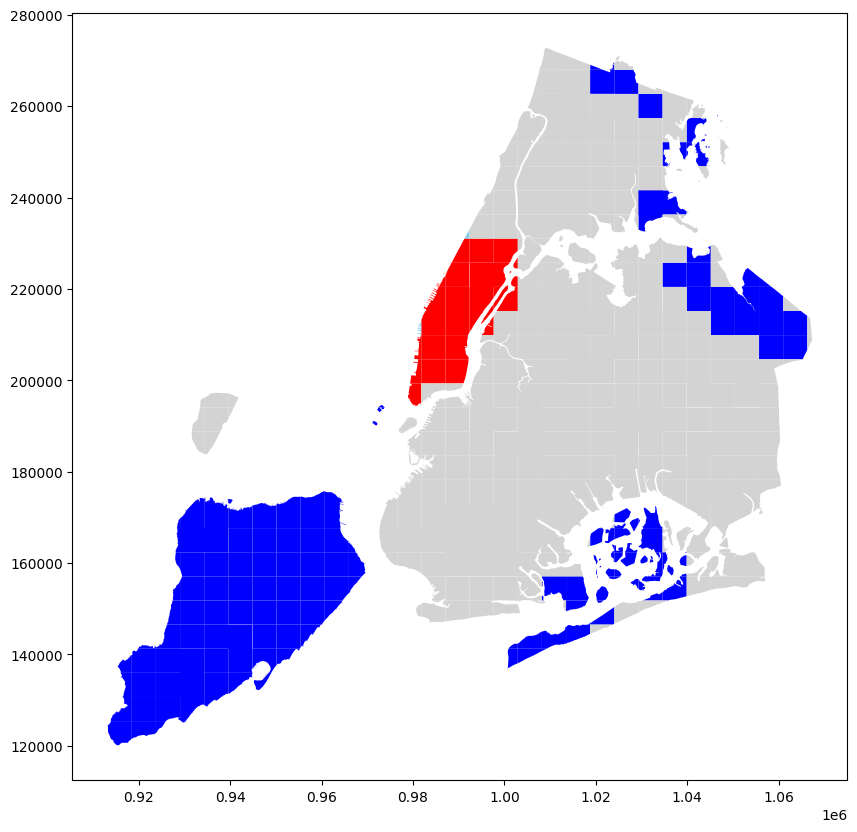

In [ ]:
lisa_color = {'HH': 'red', 'LL': 'blue', 'HL': 'orange', 'LH': 'skyblue', 'Not_Sig': 'lightgrey'}

fig, ax = plt.subplots(figsize=(10, 10))

for key in lisa_color.keys():
    grid_trip.loc[grid_trip['lisa_queen_dof_1'] == key].plot(ax=ax, color=lisa_color[key], legend=True)

plt.show()

In [14]:
m = grid_trip.explore(
    column="lisa_queen_dof_1",      # 색상을 지정할 컬럼
    cmap=['red', 'skyblue', 'blue', 'orange', 'lightgrey'],  # 색상 리스트 (HH, LH, LL, HL, Not_Sig 순)
    categories=["HH", "LH", "LL", "HL", "Not_Sig"],           # 범주 순서 명시
    legend=True,                     # 범례 표시
    tiles="CartoDB positron",       # 배경지도 스타일
    tooltip="lisa_queen_dof_1",     # 마우스오버시 보여줄 정보
    style_kwds={'fillOpacity': 0.6, 'weight': 0.5, 'color': 'black'}  # 경계선 스타일
)

In [ ]:
# m.save('/Users/jiyeonhwang/Downloads/python/공분 프로젝트/lisa_map.html')


In [45]:
for i in col_list:
    y = grid_trip[f'{i}']
    lm_queen = esda.moran.Moran_Local(y, w_queen, seed=17)
    
    # p-value를 컬럼으로 저장
    grid_trip[f'pval_{i}'] = lm_queen.p_sim

    # 기존처럼 유형도 함께 저장
    lisa_queen = []
    for idx in range(len(lm_queen.q)):
        if lm_queen.p_sim[idx] < 0.05:
            lisa_queen.append(lm_dict[lm_queen.q[idx]])
        else:
            lisa_queen.append('Not_Sig')
    grid_trip[f'lisa_{i}'] = lisa_queen

/opt/homebrew/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/opt/homebrew/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/opt/homebrew/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/opt/homebrew/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/opt/homebrew/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/opt/homebrew/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) /

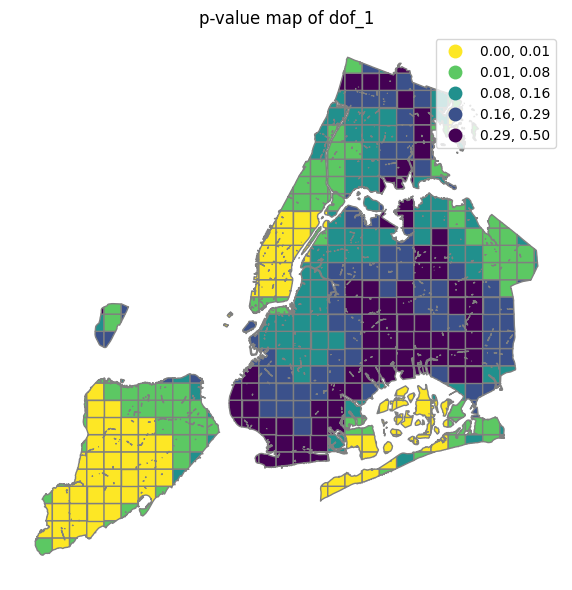

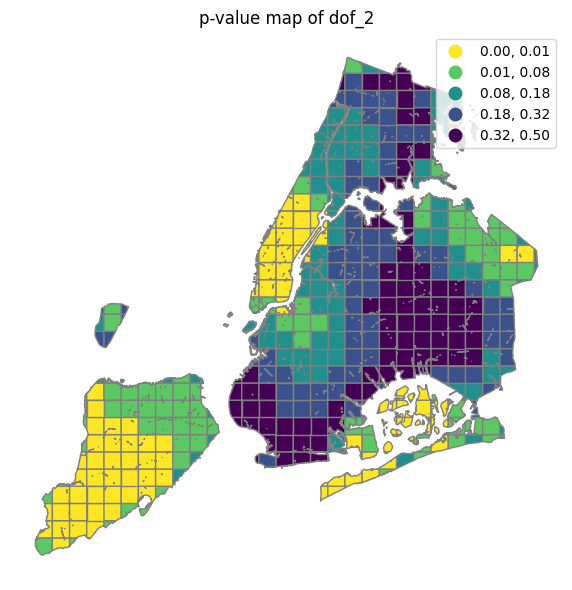

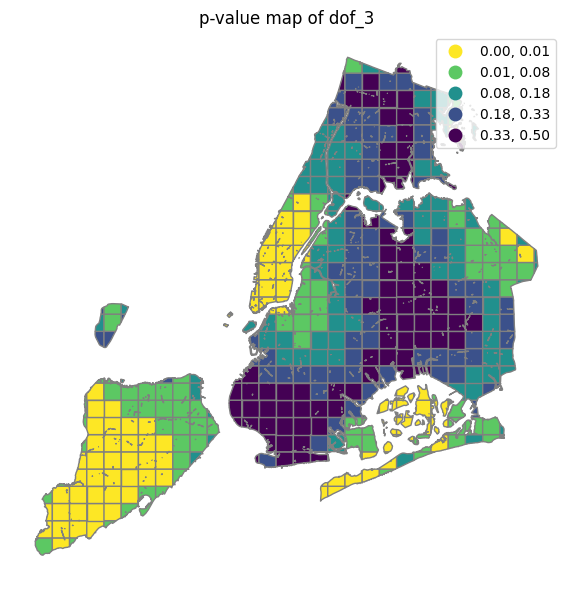

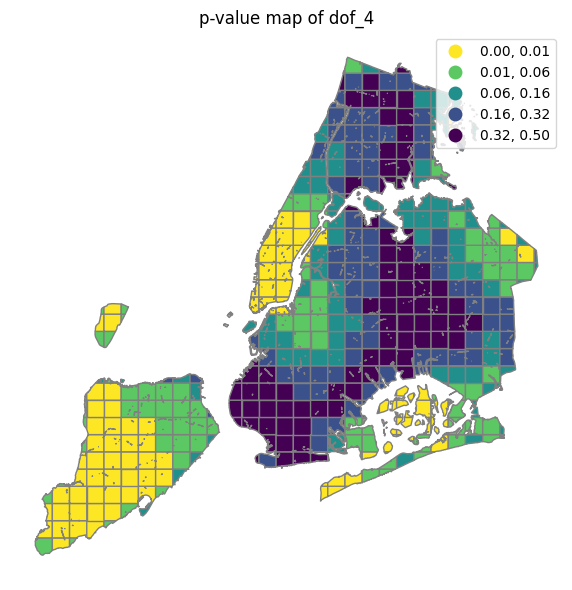

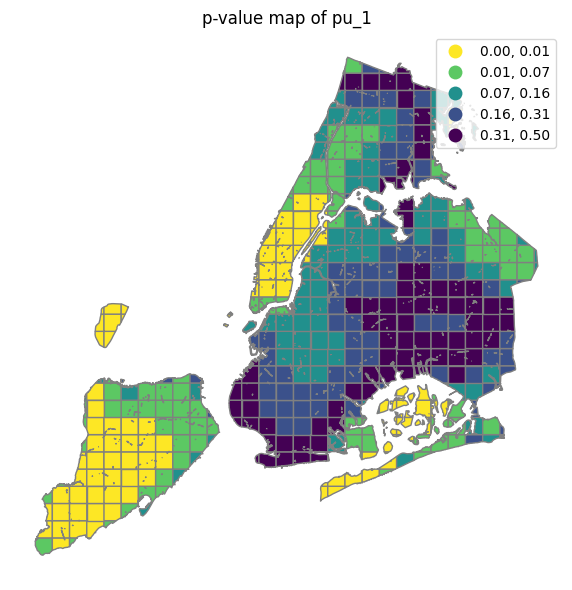

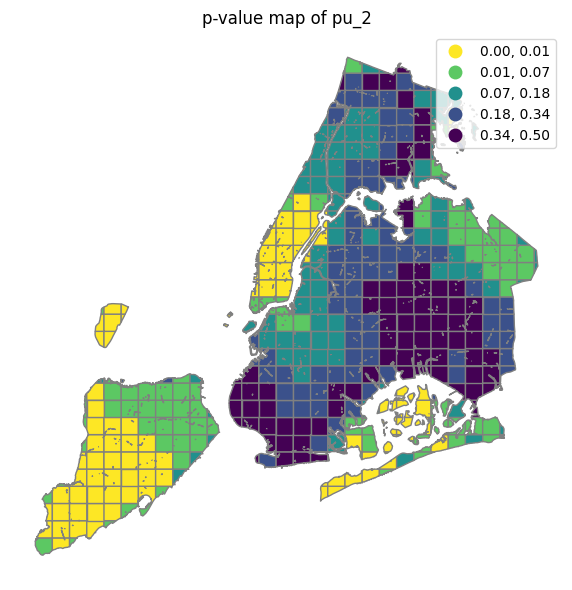

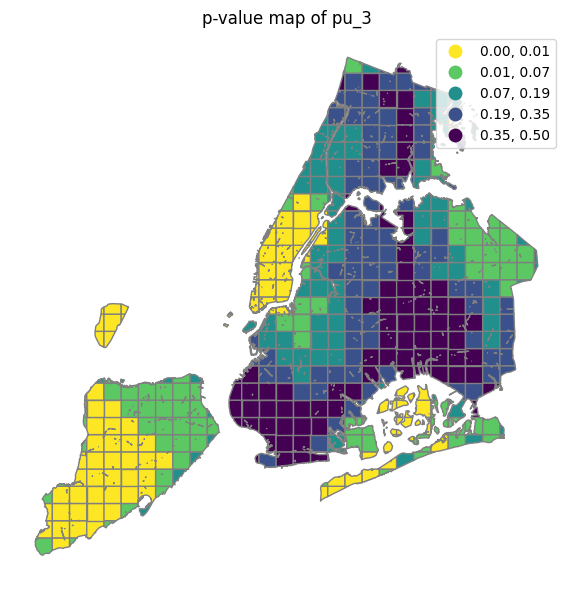

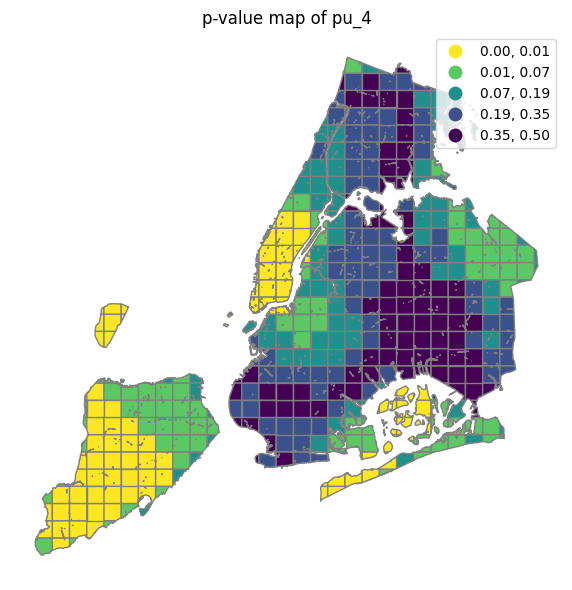

In [46]:
import matplotlib.pyplot as plt

for i in col_list:
    ax = grid_trip.plot(
        column=f'pval_{i}',
        cmap='viridis_r',  # 유의한 값은 더 어둡게, 0에 가까울수록 진한 색
        legend=True,
        scheme='quantiles',
        figsize=(8, 6),
        edgecolor='grey'
    )
    plt.title(f'p-value map of {i}')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'pval_map_{i}.png')
    plt.show()

In [47]:
def categorize_pval(p):
    if p < 0.001:
        return 'p < 0.001'
    elif p < 0.01:
        return 'p < 0.01'
    elif p < 0.05:
        return 'p < 0.05'
    else:
        return 'Not Sig'

for i in col_list:
    y = grid_trip[f'{i}']
    lm_queen = esda.moran.Moran_Local(y, w_queen, seed=17)
    
    grid_trip[f'pval_{i}'] = lm_queen.p_sim
    grid_trip[f'pval_cat_{i}'] = [categorize_pval(p) for p in lm_queen.p_sim]

/opt/homebrew/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/opt/homebrew/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/opt/homebrew/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/opt/homebrew/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/opt/homebrew/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/opt/homebrew/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) /

In [ ]:
for i in col_list:
    m = grid_trip.explore(
        column=f'pval_cat_{i}',
        cmap=['darkred', 'red', 'orange', 'lightgrey'],
        categories=['p < 0.001', 'p < 0.01', 'p < 0.05', 'Not Sig'],
        legend=True,
        tiles="CartoDB positron",
        tooltip=f"{i}",
        style_kwds={'fillOpacity': 0.6, 'weight': 0.5, 'color': 'black'}
    )
    m.save(f'/Users/jiyeonhwang/Downloads/python/공분 프로젝트/공분플젝 재분석 파일모음/pval_map_{i}.html')